# Geothermal and Machine Learning Sandbox

# Skeleton of an Variational Bayes Artificial Neural Network (BNN) in PyTorch applied to Nevada PFA Geothermal Resources Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math

import pickle

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from scipy.stats import kurtosis

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Load packages to create dataset
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset
from torch import Tensor

from torch.utils.data import WeightedRandomSampler

# from torchvision import models
from torchsummary import summary

import datetime
import time

from pathlib import Path
import sys

import h5py

from tqdm.notebook import trange, tqdm

%matplotlib inline

# Training Setup

### global variables

In [2]:
# ALPHA = 3
# ALPHA = 4
# ALPHA = 0.1

In [3]:
BATCH_SIZE = 64

In [4]:
TRAIN_EPOCHS = 1000

## BEGIN data preprocessing

## load preprocessed data

In [5]:
path = '../../datasets/'

filename = 'PFA_features&labels_march2021_tc2_imbalanced_SmoothLSS_FSS_df.h5'

hf5File = path+filename

In [6]:
f = h5py.File(hf5File, 'r')

def keys(f):
    return [key for key in f.keys()]

key_list = keys(f)
print(key_list)

f.close()

['X', 'XyInfo', 'dfInfo', 'dfn', 'nullIndexes', 'scaler', 'y']


In [7]:
dfXAll = pd.read_hdf(hf5File, key='X')
dfyAll = pd.read_hdf(hf5File, key='y')
XyInfo = pd.read_hdf(hf5File, key='XyInfo')

In [8]:
print( dfXAll.shape, dfyAll.shape, XyInfo.shape)

(725, 20) (725,) (725, 17)


In [9]:
dfXAll.head()

,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultTraces,HorizGravityGradient2,HorizMagneticGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency2,Earthquakes,Heatflow,GravityDensity,MagneticDensity,GeochemistryTemperature2,Silica_Distance,TufaOrTravertine_Distance,DEM-30m,FavorableStructuralSettings_Distance
1629211,0.605907,1.214984,3.191540,1.120474,-0.784042,0.956721,-0.383781,-1.553196,3.963975,-2.485171,0.451266,-1.352377,0.856456,-1.447685,0.042378,7.965358,-1.153277,-1.748728,0.071722,-1.439888
792748,2.753820,0.973401,0.219568,2.368457,0.743874,2.838552,-0.631091,-1.014735,-1.162640,1.180387,1.218827,0.250527,-1.224496,-1.678404,0.500513,-0.185826,0.993788,1.746996,-0.003075,0.524243
1427233,-0.532809,-0.586230,-0.402900,-0.584992,1.248917,1.627900,-0.435304,-1.246016,-0.087931,0.565757,-0.099213,-2.182920,0.426947,-1.332326,1.416784,-0.185826,0.055923,1.526730,-0.137194,1.095007
630421,0.627393,1.615954,-0.183165,1.500129,-1.064303,-1.286707,-0.662004,-0.813587,-1.262306,0.897017,0.459076,0.142340,-0.693443,0.974860,0.844115,-0.185826,1.719070,1.030348,0.948657,-1.130844
741007,-0.108018,-0.384650,-0.362674,-0.394128,-0.965216,-0.928128,-0.971141,-0.811781,-1.198261,0.909340,0.206954,-0.170018,-0.528820,-0.178733,1.416784,-0.185826,1.529526,1.298969,0.732003,-0.038541


In [10]:
dfyAll.head()

1629211    1
792748     0
1427233    0
630421     0
741007     0
Name: labels, dtype: int64

In [11]:
XyInfo.head()

,row,column,id_rc,X_83UTM11,Y_83UTM11,NullInfo,TrainCodeNeg,TrainCodePos,TrainCodePosT130,PosSite130_Id,PosSite130_Distance,PosSite_Id,PosSite_Distance,NegSite_Id,NegSite_Distance,Local_polygon_Id,Local_polygon_overlap_Id
1629211,942.0,1435.0,R943C1436,645077.690182,4.494214e+06,notNull,12,1,1,14,84.074090,14,84.074090,4,10574.081138,315,0
792748,458.0,1324.0,R459C1325,617327.690182,4.373214e+06,notNull,2,12,12,76,109719.824992,47,28269.390720,48,224.802810,24,0
1427233,825.0,1633.0,R826C1634,694577.690182,4.464964e+06,notNull,1,12,12,14,57577.584385,25,49848.864916,31,83.994037,0,0
630421,364.0,1429.0,R365C1430,643577.690182,4.349714e+06,notNull,2,12,12,13,88734.532066,55,38087.135264,41,173.133020,37,0
741007,428.0,1423.0,R429C1424,642077.690182,4.365714e+06,notNull,2,12,12,13,104234.526475,47,37025.554552,33,218.270209,0,0


In [12]:
columns=dfXAll.columns

### balance the dataset?

In [13]:
# balance = None
# balance = 'truncate'
balance = 'weighted'

### balance dataset method 1: by truncation

In [14]:
if balance == 'truncate':
    dfyAll_neg = dfyAll[dfyAll==0]
    dfyAll_pos = dfyAll[dfyAll==1]
    dfXAll_neg = dfXAll.loc[dfyAll_neg.index]
    dfXAll_pos = dfXAll.loc[dfyAll_pos.index]
    
    # find out which set is smaller
    imin = np.argmin([len(dfyAll_neg), len(dfyAll_pos)])
    
    if imin==0:
        dfyAll_pos = dfyAll_pos.sample(n=len(dfyAll_neg))
        dfXAll_pos = dfXAll_pos.loc[dfyAll_pos.index]
    elif imin==1:
        dfyAll_neg = dfyAll_neg.sample(n=len(dfyAll_pos))
        dfXAll_neg = dfXAll_neg.loc[dfyAll_neg.index]

    dfXAll = pd.concat([dfXAll_neg, dfXAll_pos])
    dfyAll = pd.concat([dfyAll_neg, dfyAll_pos])
    XyInfo = XyInfo.loc[dfXAll.index]

### balance dataset method 2: design weighted sampler for dataloaders

In [15]:
if balance == 'weighted':
    class_counts = dfyAll.value_counts()
    class_weights = class_counts/len(dfyAll)

    print(class_counts.values,  class_weights.values)

[415 310] [0.57241379 0.42758621]


### break into features and labels

In [16]:
XAll = dfXAll
yAll = dfyAll

In [17]:
XAll.shape

(725, 20)

In [18]:
yAll.shape

(725,)

In [19]:
XAll.columns

Index(['Local-StructuralSetting', 'Local-QuaternaryFaultRecency',
       'Local-QuaternaryFaultSlipDilation', 'Local-QuaternaryFaultSlipRate',
       'QuaternaryFaultTraces', 'HorizGravityGradient2',
       'HorizMagneticGradient2', 'GeodeticStrainRate', 'QuaternarySlipRate',
       'FaultRecency', 'FaultSlipDilationTendency2', 'Earthquakes', 'Heatflow',
       'GravityDensity', 'MagneticDensity', 'GeochemistryTemperature2',
       'Silica_Distance', 'TufaOrTravertine_Distance', 'DEM-30m',
       'FavorableStructuralSettings_Distance'],
      dtype='object')

In [20]:
yAll.name

'labels'

### train/test split

In [21]:
X_trainAll, X_testAll, y_trainAll, y_testAll = train_test_split(
    XAll, yAll, test_size=0.33, random_state=42)
    # XAll, yAll, test_size=0.33)

In [22]:
print (X_trainAll.shape, y_trainAll.shape, X_testAll.shape, y_testAll.shape)

(485, 20) (485,) (240, 20) (240,)


In [23]:
X_trainAll.head()

,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultTraces,HorizGravityGradient2,HorizMagneticGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency2,Earthquakes,Heatflow,GravityDensity,MagneticDensity,GeochemistryTemperature2,Silica_Distance,TufaOrTravertine_Distance,DEM-30m,FavorableStructuralSettings_Distance
851760,1.219532,1.907248,0.150295,2.039372,-0.211921,1.557584,0.296321,-1.218099,0.455146,0.218541,0.639279,-1.200670,-0.469886,-1.447685,-0.644825,-0.185826,1.339493,-1.021991,0.035613,-1.214275
918627,-0.276916,-0.203856,-0.021599,-0.403835,-1.064303,-0.292717,-0.569263,-0.811781,-0.922382,-1.454516,-0.400033,-0.787486,0.507925,-0.986248,0.156912,-0.185826,-0.351455,-1.018601,0.198104,-0.658516
1528718,-0.092083,-0.287456,-0.283656,-0.019209,-0.309676,2.304730,-0.198299,-1.537737,-0.428710,0.947958,0.481170,-0.467806,-0.467885,-1.678404,0.271446,-0.185826,-0.452455,-0.201201,-0.397695,0.010648
626965,0.564056,1.495610,-0.195161,1.386182,-1.064303,-1.304623,-0.651700,-0.813587,-1.268894,0.949120,0.460385,0.118718,-0.701636,1.090220,0.729581,-0.185826,1.724593,1.008396,0.982187,-1.091732
134427,-0.398323,-0.395663,-0.276137,-0.384507,0.095486,2.098599,-1.032969,-0.052316,0.787964,0.168520,-0.360607,0.504901,-1.420290,-1.678404,1.645851,-0.185826,1.916649,-0.381975,-0.895485,-0.793871


In [24]:
y_trainAll.head()

851760     0
918627     0
1528718    0
626965     0
134427     0
Name: labels, dtype: int64

In [25]:
print(y_trainAll.shape, y_trainAll.sum())

(485,) 275


In [26]:
columns = X_trainAll.columns.to_list()
columns

['Local-StructuralSetting',
 'Local-QuaternaryFaultRecency',
 'Local-QuaternaryFaultSlipDilation',
 'Local-QuaternaryFaultSlipRate',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'GravityDensity',
 'MagneticDensity',
 'GeochemistryTemperature2',
 'Silica_Distance',
 'TufaOrTravertine_Distance',
 'DEM-30m',
 'FavorableStructuralSettings_Distance']

## select feature set

In [27]:
featureSets = [

# MASTER SET 1
################################# 0
['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],

]

print (len(featureSets))

1


In [28]:
# featureSets

In [29]:
feature_set = 0

columns = featureSets[feature_set]

columns

['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m']

## END data preprocessing

## fix input types and dimensions

In [30]:
X_train = X_trainAll[columns].copy()
X_test = X_testAll[columns].copy()

y_train = y_trainAll.copy()
y_test = y_testAll.copy()

In [31]:
nFeatures = X_train.shape[1]
nFeatures

10

In [32]:
print (X_train.shape, y_train.shape)

(485, 10) (485,)


### balance dataset method 2: using weighted samplers in the dataloaders

In [33]:
if balance == 'weighted':

    # training dataloader sampler
    sample_weights = [1-class_weights[i] for i in y_train.to_numpy()]
    sampler = WeightedRandomSampler(weights=sample_weights, 
                                    num_samples=len(y_train), replacement=True)

    # testing dataloader sampler
    sample_weights_test = [1-class_weights[i] for i in y_test.to_numpy()]
    sampler_test = WeightedRandomSampler(weights=sample_weights_test, 
                                         num_samples=len(y_test), replacement=True)

# Build model

### use GPU

In [34]:
# setting device on GPU if available, else CPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')
print('Using device:', DEVICE)
print()

#Additional Info when using cuda
if DEVICE.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 2070
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## custom dataset class to put random numbers in certain columns each call

In [35]:
# class CustomDataset(Dataset):
#     def __init__(self, X, y, randomList=[]):
#         self.X = X.clone() # without clone this seems to retain changes in original array
#         self.y = y.clone()
#         self.randomList = randomList
        
#     def __len__(self):
#         return len(self.X)
    
#     def __getitem__(self, idx):
#         if self.randomList:
#             self.X[idx,self.randomList] = torch.rand(len(self.randomList))*0
#         return self.X[idx], self.y[idx]

In [36]:
# # test new custom datasets

# features = Tensor(X_train.to_numpy())
# labels = Tensor(y_train.to_numpy()).long()

# dataset = CustomDataset(features, labels, randomList=[9,10,11,12,13,14])
# # dataset = CustomDataset(features, labels)
# print('Number of samples in the data: ', len(dataset))
# print(dataset[2])
# print(dataset[0:5])

In [37]:
# feature columns to continually randomize

# randomList = [9,10,11,12,13,14]

## create datasets and batch loaders

In [38]:
###################################################################
# Create train dataset from several tensors with matching first dimension
features = Tensor(X_train.to_numpy())
labels = Tensor(y_train.to_numpy()).long()

train_dataset = TensorDataset( features, labels )
# train_dataset = CustomDataset( features, labels, randomList ) # randomize certain columns

# Create a data loader from the dataset
if balance == None or balance == 'truncate':
    # Type of sampling and batch size are specified at this step
    train_loader = DataLoader(train_dataset, shuffle=True, 
                              batch_size=BATCH_SIZE, drop_last=True)

if balance == 'weighted':
    # weighted sampler to balance training data
    train_loader = DataLoader(train_dataset, sampler=sampler, 
                              batch_size=BATCH_SIZE, drop_last=True)

###################################################################
# Create test dataset from several tensors with matching first dimension
features = Tensor(X_test.to_numpy())
labels = Tensor(y_test.to_numpy()).long()

test_dataset = TensorDataset( features, labels )
# test_dataset = CustomDataset( features, labels, randomList ) # randomize certain columns

# Create a data loader from the dataset
if balance == None or balance == 'truncate':
    test_loader = DataLoader(test_dataset, shuffle=False, 
                             batch_size=BATCH_SIZE, drop_last=True)

if balance == 'weighted':
    # need this weighted sampler to balance testing data too, 
    #      otherwise learning curves are odd
    # a weighted test_loader is a good substitute for the required weighting 
    #      of the test accuracy in imbalanced cases ... 
    #      since accuracies are means over epochs statistics are incorrect without it
    #
    # test_loader = DataLoader(test_dataset, shuffle=False, 
    #                          batch_size=batch_size, drop_last=False)
    # test_loader = DataLoader(test_dataset, sampler=sampler_test, 
                             # batch_size=batch_size, drop_last=False)
    test_loader = DataLoader(test_dataset, sampler=sampler_test, 
                             batch_size=BATCH_SIZE, drop_last=True)    

## vanilla pytorch bayes by backprop

In [39]:
class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
#         epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
        epsilon = self.normal.sample().to(DEVICE)
        return self.mu + self.sigma * epsilon
    
    def entropy(self, input):
#         entropy = 0.5 * torch.log(2 * math.pi * math.e * self.sigma**2)
        entropy = -self.normal.log_prob(input).exp() * self.normal.log_prob(input)
        return entropy.sum()

    def log_prob(self, input):
        return (- math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

In [40]:
from scipy.stats import gennorm

class GenNormal(object):
    def __init__(self, beta, scale):
        super().__init__()
        self.beta = beta.cpu().numpy()
        self.scale = scale.cpu().numpy()
        self.gennormal = gennorm(self.beta, loc=0.0, scale=self.scale)
    
    @property
    def sigma(self):
        return self.gennormal.std()
    
    def sample(self):
        rv = self.gennormal.rvs(self.scale.shape[0])
        rv = torch.FloatTensor(rv).to(DEVICE)
        return rv
    
    def entropy(self, input):
        x = input.cpu().detach().numpy()
        entropy = -self.gennormal.pdf(x) * self.gennormal.logpdf(x)
        entropy = torch.FloatTensor(entropy)
        return entropy.sum()

    def log_prob(self, input):
        x = input.cpu().detach().numpy()
#         x = input
        logprob = self.gennormal.logpdf(x)
        logprob = torch.FloatTensor(logprob)
        return logprob.sum()

In [41]:
class Normal(object):
    def __init__(self, scale):
        super().__init__()
        self.scale = scale
        self.normal = torch.distributions.Normal(loc=0.0, scale=self.scale)
        
    def sample(self):
        sample = self.normal.sample().to(DEVICE)
        return sample
    
    def entropy(self):
        entropy = self.normal.entropy()
        return entropy

    def log_prob(self, input):
        prob = self.normal.log_prob(input)
        return prob.sum()

## prior starting parameters

In [42]:
BETAw = torch.FloatTensor([10]).to(DEVICE)
BETAb = torch.FloatTensor([10]).to(DEVICE)

SCALEw = torch.FloatTensor([0.3]).to(DEVICE)
SCALEb = torch.FloatTensor([0.3]).to(DEVICE)

## view the prior

In [43]:
prior = Normal(SCALEw)
# prior = GenNormal(BETAw, SCALEw)

In [44]:
prior_x = torch.FloatTensor(np.linspace(-10,10,1000))
# print(x)
# x = (np.linspace(-5,5,1000))
prior_pdf = np.array([])
for xsample in prior_x:
#     xsample = xsample.cpu()
    p = np.exp(prior.log_prob(xsample).cpu().numpy())
    prior_pdf = np.append(prior_pdf, p)    

In [45]:
prior_samples=np.array([])
for i in range(10000):
    sample = prior.sample()
    if abs(sample) < 10:
        prior_samples = np.append(prior_samples,sample.cpu().detach().numpy())
    
kurs = kurtosis(prior_samples, fisher=False)

print (kurs)

3.038360503467932


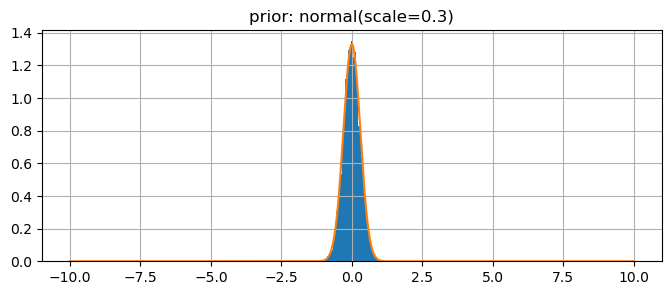

In [46]:
plt.rc('figure', figsize=(8, 3))

plt.hist(prior_samples, 50, density=True, label='prior');
plt.plot(prior_x, prior_pdf);
plt.grid(True)

# plt.xlim(-0.5,0.5)

plt.title('prior: normal(scale='+str(SCALEw.cpu().numpy()[0])+')');
# plt.title('prior: gennormal(beta=10, scale=0.3');
# plt.savefig('figures/prior-gennormal.png')

# plt.savefig('figures/prior-normal('+str(SCALEw.cpu().numpy()[0])+')'+'.png')


In [47]:
from sklearn import mixture

In [48]:
X = prior_samples.reshape(-1, 1)

In [49]:
# gmm = mixture.GaussianMixture(n_components = 2, max_iter=100000, covariance_type='diag').fit(X)
gmm = mixture.BayesianGaussianMixture(n_components = 2, max_iter=100000).fit(X)

In [50]:
print (gmm.means_.squeeze())
print ("")
print (np.sqrt(gmm.covariances_).squeeze())

[-0.07245657  0.07475958]

[0.29296279 0.28856363]


## Bayesian modules

In [51]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features

        # Weight parameters
        self.weight_mu  = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        
        # Bias parameters
        self.bias_mu  = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        
        # Prior distributions
#         self.weight_prior = GenNormal(BETAw, SCALEw)
#         self.bias_prior   = GenNormal(BETAb, SCALEb)

        self.weight_prior = Normal(SCALEw)
        self.bias_prior   = Normal(SCALEb)

        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input, weight, bias)

In [52]:
class BayesianNetwork(nn.Module):
    def __init__(self, nFeatures, nHidden, nLabels, complexityWeight):
        super().__init__()
        self.nFeatures = nFeatures
        self.nHidden   = nHidden
        self.nLabels   = nLabels
        
        self.complexityWeight = complexityWeight
        
        self.l1 = BayesianLinear(self.nFeatures, self.nHidden)
        self.l2 = BayesianLinear(self.nHidden, self.nHidden)
        self.l3 = BayesianLinear(self.nHidden, self.nLabels)
        
        self.LeakyRelu  = nn.LeakyReLU(0.1)
        self.BatchNorm  = nn.BatchNorm1d(self.nHidden)
        self.dropout    = nn.Dropout(p=0.3)
        self.LogSoftmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x, sample=False):
        x = x.view(-1, self.nFeatures)
        
        x = self.l1(x, sample)
#         x = self.BatchNorm(x)
        x = self.LeakyRelu(x)

        x = self.l2(x, sample)
        x = self.LeakyRelu(x)

        x = self.l3(x, sample)
        x = self.LogSoftmax(x)
        
        return x
    
    def mfvi_forward(self, inputs, stat=None, q=None, sample_nbr=10):
        """
        Perform mean-field variational inference for the variational estimator model:
            Performs sample_nbr forward passes with uncertainty on the weights, 
            returning its mean and standard deviation
        """
        # logits from all samples - are these logsoftmax called logits?
        logits = torch.stack([self(inputs, sample=True) for _ in range(sample_nbr)])
        # convert logits to probability
        probability = torch.exp(logits)
        
        if   stat == 'mean':
            value = torch.mean(probability, dim=0)
        elif stat == 'stddev':
            value = torch.std(probability, dim=0)
        elif stat == 'mode':
            value, _ = torch.mode(probability, dim=0)
        elif stat == 'quantile':
            value = torch.quantile(probability, q, dim=0)
        else:
            value = torch.tensor([0.0])            
        return value

    def log_prior(self):
        return self.l1.log_prior \
               + self.l2.log_prior \
               + self.l3.log_prior
    
    def log_variational_posterior(self):
        return self.l1.log_variational_posterior \
               + self.l2.log_variational_posterior \
               + self.l3.log_variational_posterior
    
    def get_weights(self, param):
        if param == 'samples':
            return self.l1.weight.sample(), self.l2.weight.sample(), self.l3.weight.sample()
        elif param == 'sigmas':
            return self.l1.weight.sigma, self.l2.weight.sigma, self.l3.weight.sigma
        elif param == 'means':
            return self.l1.weight.mu, self.l2.weight.mu, self.l3.weight.mu
    
    def get_biases(self, param):
        if param == 'samples':
            return self.l1.bias.sample(), self.l2.bias.sample(), self.l3.bias.sample()
        elif param == 'sigmas':
            return self.l1.bias.sigma, self.l2.bias.sigma, self.l3.bias.sigma
        elif param == 'means':
            return self.l1.bias.mu, self.l2.bias.mu, self.l3.bias.mu

    def sample_elbo(self, input, target, samples=3):
        outputs = torch.zeros(samples, BATCH_SIZE, self.nLabels).to(DEVICE)
        log_priors = torch.zeros(samples).to(DEVICE)
        log_variational_posteriors = torch.zeros(samples).to(DEVICE)
        
        for i in range(samples):
            outputs[i] = self(input, sample=True) # this is same as "forward"
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()

        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()

        negative_log_likelihood = F.nll_loss(outputs.mean(0), target, reduction='mean')

        loss = self.complexityWeight*(log_variational_posterior - log_prior) + negative_log_likelihood

        return loss, log_prior, log_variational_posterior, negative_log_likelihood

In [53]:
def train(net, optimizer, epoch):
    
    ###########
    net.train()
    total = 0
    total_loss = 0.0
    total_log_prior = 0.0
    total_log_variational_posterior = 0.0
    total_negative_log_likelihood = 0.0
    for batch_idx, (features, labels) in enumerate(train_loader):
        features, labels = features.to(DEVICE), labels.to(DEVICE)
        net.zero_grad()
        loss, log_prior, log_variational_posterior, negative_log_likelihood = net.sample_elbo(features, labels)
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        total_loss += loss.cpu().detach().numpy()
        total_log_prior += log_prior.cpu().detach().numpy()
        total_log_variational_posterior += log_variational_posterior.cpu().detach().numpy()
        total_negative_log_likelihood += negative_log_likelihood.cpu().detach().numpy()
        
    epoch_loss = total_loss / total
    epoch_log_prior = total_log_prior / total
    epoch_log_variational_posterior = total_log_variational_posterior / total
    epoch_negative_log_likelihood = total_negative_log_likelihood / total

    ###########
    net.eval()
    # average train accuracy per epoch ... since this is an average they should be weighted
    correct = 0
    total = 0
    with torch.no_grad():
        for data in train_loader:
            features, labels = data
            outputs = net(features.to(DEVICE), sample=True)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(DEVICE)).sum().item()

    epoch_train_acc = 100 * correct / total
    
    # average test accuracy per epoch ... since this is an average they should be weighted
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            features, labels = data
            outputs = net(features.to(DEVICE), sample=True)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(DEVICE)).sum().item()

    epoch_test_acc = 100 * correct / total

    return epoch_loss, epoch_train_acc, epoch_test_acc, \
            epoch_log_prior, epoch_log_variational_posterior, epoch_negative_log_likelihood

In [54]:
def evaluate(net, epoch):
    
    ###########
    net.eval()
    total = 0
    total_loss = 0.0
    total_log_prior = 0.0
    total_log_variational_posterior = 0.0
    total_negative_log_likelihood = 0.0
    for batch_idx, (features, labels) in enumerate(train_loader):
        features, labels = features.to(DEVICE), labels.to(DEVICE)
#         net.zero_grad()
        loss, log_prior, log_variational_posterior, negative_log_likelihood = net.sample_elbo(features, labels)
#         loss.backward()
#         optimizer.step()
        total += labels.size(0)
        total_loss += loss.cpu().detach().numpy()
        total_log_prior += log_prior.cpu().detach().numpy()
        total_log_variational_posterior += log_variational_posterior.cpu().detach().numpy()
        total_negative_log_likelihood += negative_log_likelihood.cpu().detach().numpy()
        
    epoch_loss = total_loss / total
    epoch_log_prior = total_log_prior / total
    epoch_log_variational_posterior = total_log_variational_posterior / total
    epoch_negative_log_likelihood = total_negative_log_likelihood / total

    ###########
    net.eval()
    # average train accuracy per epoch
    correct = 0
    total = 0
    with torch.no_grad():
        for data in train_loader:
            features, labels = data
            outputs = net(features.to(DEVICE), sample=True)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(DEVICE)).sum().item()

    epoch_train_acc = 100 * correct / total
    
    # average test accuracy per epoch
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            features, labels = data
            outputs = net(features.to(DEVICE), sample=True)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(DEVICE)).sum().item()

    epoch_test_acc = 100 * correct / total

    return epoch_loss, epoch_train_acc, epoch_test_acc, \
            epoch_log_prior, epoch_log_variational_posterior, epoch_negative_log_likelihood

## model instance

### settings

In [55]:
TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)

# total number of probabilistic weights + biases
nHidden = 16
nLabels = 2
nBayesianModules = nFeatures*nHidden + \
                     nHidden*nHidden + \
                     nHidden*nLabels + \
                     nHidden + nHidden + nLabels

weightScales = np.around(np.logspace(np.log10(1),np.log10(5),30),3)
# weightScales = np.around(np.logspace(np.log10(1),np.log10(5),10), 3)
# weightScales=[3]

In [56]:
weightScales

array([1.   , 1.057, 1.117, 1.181, 1.249, 1.32 , 1.395, 1.475, 1.559,
       1.648, 1.742, 1.841, 1.946, 2.057, 2.175, 2.299, 2.43 , 2.569,
       2.715, 2.87 , 3.034, 3.207, 3.39 , 3.584, 3.788, 4.005, 4.233,
       4.475, 4.73 , 5.   ])

In [57]:
len(weightScales)

30

In [58]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [59]:
def to_class(ypred,threshold):
    yclass = np.zeros(ypred.shape,dtype='int')
    yclass[ypred > threshold] = 1
    return yclass

### main loop over weightScales

In [60]:
results = []
scores = []
confusions = []

for weightScale in weightScales:
    
    try:
        del net
        del optimizer
        del scheduler
    except:
        pass

    complexityWeight = weightScale/nBayesianModules
#     print ('weight scale = ',weightScale)

    ###################################################
    # instantiate
    net = BayesianNetwork(nFeatures, nHidden, nLabels, complexityWeight).to(DEVICE)

    optimizer = optim.Adam(net.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.5, verbose=True)

    ###################################################
    # train
    
    epoch_train_loss = []
    epoch_train_acc = []
    epoch_test_acc = []

    epoch_logprior = []
    epoch_logvarprior = []
    epoch_negloglikelihood = []

    for epoch in tqdm(range(TRAIN_EPOCHS)):
        eloss, etrain_acc, etest_acc, elogprior, elogvarprior, enegloglikelihood \
            = train(net, optimizer, epoch)

    # check to see how sampling of trained network looks
    #     eloss, etrain_acc, etest_acc, elogprior, elogvarprior, enegloglikelihood \
    #         = evaluate(net, epoch)

        # adjust learning rate
        # scheduler.step()
        scheduler.step(eloss)

        epoch_train_loss.append(eloss)
        epoch_train_acc.append(etrain_acc)
        epoch_test_acc.append(etest_acc)

        epoch_logprior.append(elogprior)
        epoch_logvarprior.append(elogvarprior)
        epoch_negloglikelihood.append(enegloglikelihood)            

    train_loss = np.asarray(epoch_train_loss)
    train_acc = np.asarray(epoch_train_acc)
    test_acc = np.asarray(epoch_test_acc)

    train_logprior = np.asarray(epoch_logprior)
    train_logvarprior = np.asarray(epoch_logvarprior)
    train_negloglikelihood = np.asarray(epoch_negloglikelihood)


    ###################################################
    # get weight and biases parameters

    param = 'means'
    weightsM = np.hstack([net.get_weights(param)[0].cpu().detach().numpy().flatten(), 
                         net.get_weights(param)[1].cpu().detach().numpy().flatten(),
                         net.get_weights(param)[2].cpu().detach().numpy().flatten()])
    biasesM  = np.hstack([net.get_biases(param)[0].cpu().detach().numpy().flatten(), 
                         net.get_biases(param)[1].cpu().detach().numpy().flatten(),
                         net.get_biases(param)[2].cpu().detach().numpy().flatten()])

    param = 'sigmas'
    weightsS = np.hstack([net.get_weights(param)[0].cpu().detach().numpy().flatten(), 
                         net.get_weights(param)[1].cpu().detach().numpy().flatten(),
                         net.get_weights(param)[2].cpu().detach().numpy().flatten()])
    biasesS  = np.hstack([net.get_biases(param)[0].cpu().detach().numpy().flatten(), 
                         net.get_biases(param)[1].cpu().detach().numpy().flatten(),
                         net.get_biases(param)[2].cpu().detach().numpy().flatten()])

    param = 'samples'
    weightSamples = np.array([])
    for i in range(1000):
        sample = np.hstack([net.get_weights(param)[0].cpu().detach().numpy().flatten(), 
                    net.get_weights(param)[1].cpu().detach().numpy().flatten(),
                    net.get_weights(param)[2].cpu().detach().numpy().flatten()])
        weightSamples = np.append(weightSamples,sample)
        
    print (weightSamples.shape)

    ###################################################
    # derive number of degrees of freedom from S2N of weights
    
    weightsS2N = np.abs(weightsM/weightsS)
    weightsS2N = np.sort(weightsS2N)

    idx = np.where(weightsS2N >= 1)[0]
    nDOF = len(idx)

    ###################################################
    # fit probability for entropy estimate
    X = weightsM.copy().reshape(-1, 1)

    ### gennorm
    params = gennorm.fit(X)

    final_differential_entropy = gennorm.entropy(params[0],loc=params[1],scale=params[2])
    initial_differential_entropy = prior.entropy().cpu().detach().numpy()[0]
    entropy_change = initial_differential_entropy - final_differential_entropy

    ###################################################
    # AIC & BIC
    Loss = np.array([])
    for i in range(1024):
        with torch.no_grad():
            features = Tensor(X_train.to_numpy())
            labels = Tensor(y_train.to_numpy()).long()
            outputs = net(features.to(DEVICE), sample=True)
            loss = torch.nn.NLLLoss()(outputs, labels.to(DEVICE))
            Loss = np.append(Loss, loss.cpu().detach().numpy())
    Loss = Loss.mean()
    
    AIC = 2*Loss + 2*nDOF
    BIC = 2*Loss + np.log(TRAIN_SIZE)*nDOF
    
    AICc = AIC + (2*nDOF*(nDOF+1))/(TRAIN_SIZE-nDOF-1)
    
    ###################################################
    avgTrainAcc = train_acc[-100:].mean()
    avgTestAcc = test_acc[-100:].mean()
    
    ###################################################
    result = [weightScale,
              Loss, nDOF, 
              entropy_change, BIC, 
              AIC, AICc, 
              avgTrainAcc, avgTestAcc]
    
    ###################################################
    # classification report
    
    X = X_test.to_numpy()
    y = y_test.to_numpy()

    net.eval()
    net.to(DEVICE)
    features = Tensor(X).to(DEVICE)

    with torch.no_grad():
        p = net.mfvi_forward(features, stat='mean', q=None, sample_nbr=1024)
        # m = p[0].squeeze() # means
    
    ypred = p[:,1].cpu()
    
    threshold = 0.5
    yclass = to_class(ypred, threshold)
    
    y_true = y.squeeze()
    y_pred = yclass.squeeze()

    score = [weightScale,
             precision_score(y_true, y_pred, average="macro"),
             recall_score(y_true, y_pred , average="macro"),
             f1_score(y_true, y_pred , average="macro"),
             roc_auc_score(y_true, y_pred)]
    
    confusion = [weightScale]+confusion_matrix(y_true, y_pred).flatten().tolist()

    ###################################################
    results.append(result)
    scores.append(score)
    confusions.append(confusion)

    print ('')

results = np.array(results)
scores = np.array(scores)
confusions = np.array(confusions)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00738: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00839: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00940: reducing learning rate of group 0 to 1.2500e-04.
(448000,)



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00687: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00933: reducing learning rate of group 0 to 2.5000e-04.
(448000,)



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00688: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00789: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00890: reducing learning rate of group 0 to 1.2500e-04.
(448000,)



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00843: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00944: reducing learning rate of group 0 to 2.5000e-04.
(448000,)



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00704: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00805: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00906: reducing learning rate of group 0 to 1.2500e-04.
(448000,)



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00845: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00946: reducing learning rate of group 0 to 2.5000e-04.
(448000,)



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00646: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00760: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00861: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00962: reducing learning rate of group 0 to 6.2500e-05.
(448000,)



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00756: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00857: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00966: reducing learning rate of group 0 to 1.2500e-04.
(448000,)



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00715: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00816: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00917: reducing learning rate of group 0 to 1.2500e-04.
(448000,)



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00650: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00751: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00852: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00953: reducing learning rate of group 0 to 6.2500e-05.
(448000,)



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00672: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00773: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00874: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00975: reducing learning rate of group 0 to 6.2500e-05.
(448000,)



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00708: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00809: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00910: reducing learning rate of group 0 to 1.2500e-04.
(448000,)



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00701: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00802: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00903: reducing learning rate of group 0 to 1.2500e-04.
(448000,)



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00549: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00664: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00765: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00866: reducing learning rate of group 0 to 6.2500e-05.
Epoch 00967: reducing learning rate of group 0 to 3.1250e-05.
(448000,)



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00650: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00751: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00852: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00953: reducing learning rate of group 0 to 6.2500e-05.
(448000,)



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00710: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00811: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00912: reducing learning rate of group 0 to 1.2500e-04.
(448000,)



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00734: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00835: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00936: reducing learning rate of group 0 to 1.2500e-04.
(448000,)



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00659: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00760: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00861: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00962: reducing learning rate of group 0 to 6.2500e-05.
(448000,)



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00665: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00766: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00867: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00968: reducing learning rate of group 0 to 6.2500e-05.
(448000,)



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00705: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00806: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00907: reducing learning rate of group 0 to 1.2500e-04.
(448000,)



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00702: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00803: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00904: reducing learning rate of group 0 to 1.2500e-04.
(448000,)



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00646: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00747: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00848: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00949: reducing learning rate of group 0 to 6.2500e-05.
(448000,)



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00607: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00708: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00809: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00910: reducing learning rate of group 0 to 6.2500e-05.
(448000,)



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00630: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00731: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00832: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00933: reducing learning rate of group 0 to 6.2500e-05.
(448000,)



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00724: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00825: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00926: reducing learning rate of group 0 to 1.2500e-04.
(448000,)



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00620: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00721: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00822: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00923: reducing learning rate of group 0 to 6.2500e-05.
(448000,)



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00637: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00738: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00839: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00940: reducing learning rate of group 0 to 6.2500e-05.
(448000,)



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00629: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00730: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00831: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00932: reducing learning rate of group 0 to 6.2500e-05.
(448000,)



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00668: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00769: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00870: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00971: reducing learning rate of group 0 to 6.2500e-05.
(448000,)



  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00602: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00703: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00804: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00905: reducing learning rate of group 0 to 6.2500e-05.
(448000,)



/home/srbrown/mambaforge/envs/pytorchGeo/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
summary_dict = {'nFeatures': nFeatures, 
                'featureNames': columns,
                'results': results, 
                'scores': scores, 
                'confusions': confusions}

summary_filename = 'summary_results_test.pkl'

# write python dict to a file
with open(summary_filename, 'wb') as fout:
    pickle.dump(summary_dict, fout,
                protocol=pickle.HIGHEST_PROTOCOL)


In [62]:
# read python dict back from the file
with open(summary_filename, 'rb') as fin:
    summary_dict2 = pickle.load(fin)

In [63]:
summary_dict2.keys()

dict_keys(['nFeatures', 'featureNames', 'results', 'scores', 'confusions'])

In [64]:
summary_dict2['confusions'].shape

(30, 5)

## plot all model results

0 0 1 data loss
0 1 2 # DOF
1 0 3 $\Delta$ S
1 1 4 BIC
2 0 5 AIC
2 1 6 AICc
3 0 7 train acc
3 1 8 test acc


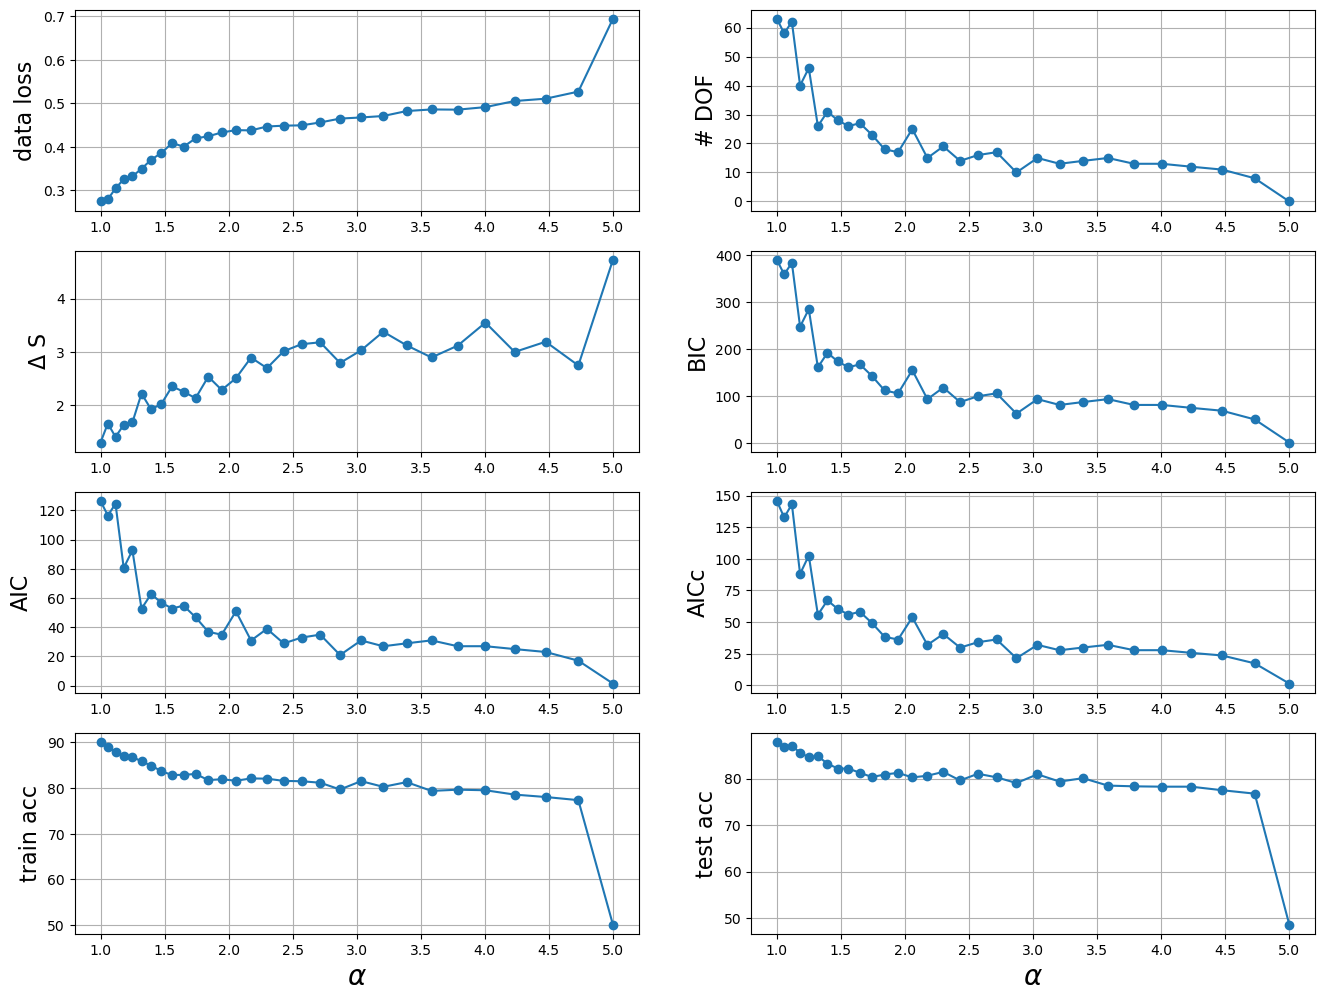

In [65]:
# plt.rc('figure', figsize=(16, 12))

rowcol = np.array([[1,2],
                   [3,4],
                   [5,6],
                   [7,8]])

ytxt = np.array([['data loss', '# DOF'], 
                 [r'$\Delta$ S', 'BIC'], 
                 ['AIC', 'AICc'], 
                 ['train acc', 'test acc']])

rows, cols = 4, 2

fig, axes = plt.subplots(rows,cols, figsize=(16, 12))
for row in range(rows):
    for col in range(cols):
        print(row, col, rowcol[row,col], ytxt[row,col])
        axes[row,col].plot(results[:,0], results[:,rowcol[row,col]], '-o')
        
        axes[row,col].grid(True)
        axes[row,col].set_ylabel(ytxt[row,col], fontsize=16)
        if row==3:
            axes[row,col].set_xlabel(r'$\alpha$', fontsize=20)
                                                 
# plt.savefig('bayes_loop.png')

## plot more

1
2
3
4


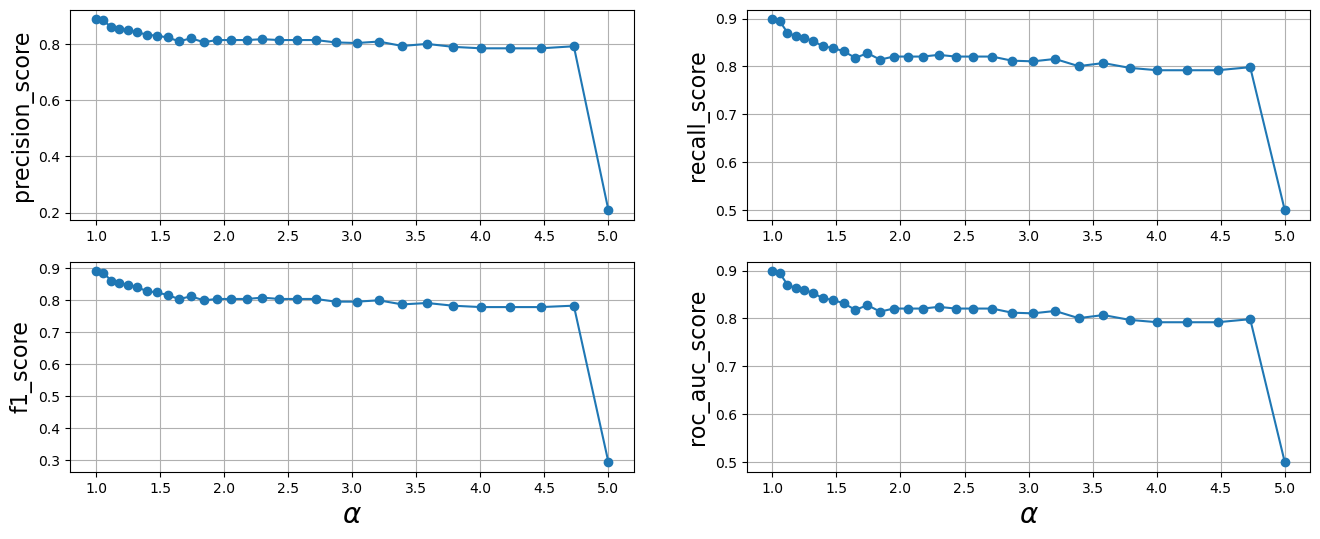

In [66]:
%matplotlib inline

plt.rc('figure', figsize=(16, 6))

rowcol = np.array([[1,2],
                   [3,4]])

ytxt = np.array([['precision_score', 'recall_score'], 
                 ['f1_score', 'roc_auc_score']])

rows, cols = 2, 2

fig, axes = plt.subplots(rows,cols)
for row in range(rows):
    for col in range(cols):
        print (rowcol[row,col])
        axes[row,col].plot(scores[:,0], scores[:,rowcol[row,col]], '-o')
        
        axes[row,col].grid(True)
        axes[row,col].set_ylabel(ytxt[row,col], fontsize=16)
        if row==1:
            axes[row,col].set_xlabel(r'$\alpha$', fontsize=20)